# Notes
*highlighted terms are the tunable params*
- CDH1 expression: Ms layer (smoothed)
- Validate gsva terms in tcga: if KOhi terms are high in ILC than IDC; WThi terms high in IDC than ILC
    - select only `LumA` as other PAM50 do not really have ILCs; here the two groups (IDC & ILC have comparable size: 200 IDCs vs 106 ILCs
    - did not use original GO terms for ks stats, but `overlapped genes` (original GO terms do not show trends); and only used terms with `FDR<0.05`, `gsva` results.
    
- Regulons binarization
    - used `raw` AUC data (not normalized anyway) => distribution of the regulon activity => set `threshold` using sklearn method (the same in Scrubblet)
    - Calling ilc tfs: 1st, call bulk on/off: vote over `50%`; 2nd, for the 3 ilcs and 2 wt idcs, for a certain tf, if >=2 ILCs have it one AND at >=1 IDCs have it off, then it is defined as ilc tfs to be tested in TCGA. 
    - The testing method (following above) are 2 ways: 1. directly test TF expression diff in ILC and IDCs; 2. test the GSVA of that TF's geneset (i.e. regulon). The first is straightforward and used `FDR<0.05` also => 6 out of 8 tfs tested have higher expression in TCGA ILCs
    - For the second, it is ambiguous as regulons recovered from each cell type can be different - to `define 'regulons'` of these master TFs: if 1 gene is counted in a certain regulons by >=2 ILCs then it is defined to belong to this regulon.
    - In the above situation, only IRF1 nevertheless show both tf and GSVA gene set upregulation. Thus only focus on it. For the others, the resulting gene set size is too big.
    - Meanwhile, `IRF1` regulon is the one that is activated in KO than WT, from the respective regulon structures.

In [4]:
import scanpy as sc
from plot import plot_enrich, patchplot

# DEG

## DEGs

In [ ]:
adata_raw = sc.read('../data/scVelo/AL1_ref_raw.h5ad')
AL1 = sc.read('../data/scVelo/AL1.h5ad') # they have identical obs index
adata_raw.obs = AL1.obs 
t47d = adata_raw[AL1.obs['CellType'].isin(['T47D WT','T47D KO'])]

t47d.var_names_make_unique()
n_top_genes = 3000

scv.pp.filter_genes(t47d, min_cells=2)
scv.pp.filter_genes_dispersion(t47d, flavor='seurat', n_top_genes=n_top_genes)
scv.pp.normalize_per_cell(t47d, layers=['spliced', 'unspliced']) # 3 layers all been normalized by / cts
scv.pp.log1p(t47d) # only t47d.X is log1p (loge(x+1))
scv.pp.moments(t47d, n_pcs=30, n_neighbors=30, mode='connectivities', method='umap', use_rep=None)

In [4]:
t47d 

AnnData object with n_obs × n_vars = 1000 × 3000 
    obs: 'Clusters', '_X', '_Y', 'doublet_bln', 'doublet_score', 'percent_mito', 'n_counts', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'louvain', 'CellType', 'phase'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'

### writing ref_norm for t47d only
``` python
adata_raw = sc.read('../data/scVelo/AL1_ref_raw.h5ad')
AL1 = sc.read('../data/scVelo/AL1.h5ad') # they have identical obs index
adata_raw.obs = AL1.obs 
t47d = adata_raw[AL1.obs['CellType'].isin(['T47D WT','T47D KO'])]

t47d.var_names_make_unique()

scv.pp.filter_genes(t47d, min_cells=2)
scv.pp.normalize_per_cell(t47d, layers=['spliced', 'unspliced']) # 3 layers all been normalized by / cts
scv.pp.log1p(t47d) # only t47d.X is log1p (loge(x+1))
scv.pp.moments(t47d, n_pcs=30, n_neighbors=30, mode='connectivities', method='umap', use_rep=None)

t47d.write('../data/scVelo/t47d.ref_norm.h5ad')
```

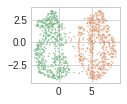

In [9]:
plt.style.use(['seaborn-whitegrid'])

X = t47d.obsm['X_umap']

CellTypeMapper = t47d.obs['CellType']
types = np.array(t47d.obs['CellType'].dtype.categories)
clist_types = sns.color_palette(palette='deep', desat=1)
row_colors = [clist_types[np.where(types==CellTypeMapper[bc])[0][0]+1] for bc in t47d.obs.index]

fig = plt.figure(figsize=(1.6,1.4))
plt.scatter(X[:,0], X[:,1], color=row_colors, s=.5, alpha=0.5)
plt.savefig('../Figure/Fig4/UmapT47d.pdf', bbox_inches='tight')

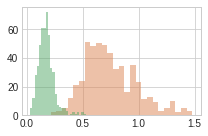

In [10]:
wt = t47d[t47d.obs['CellType']=='T47D WT']
ko = t47d[t47d.obs['CellType']=='T47D KO']

x1 = np.array(wt[:,'CDH1'].layers['Ms'])
x2 = np.array(ko[:,'CDH1'].layers['Ms'])

clist = sns.color_palette(palette='deep', desat=1)

fig = plt.figure(figsize=(3.2,2))
plt.hist(x1, color=clist[1], bins=25, alpha=0.5)
plt.hist(x2, color=clist[2], bins=25, alpha=0.5)

plt.savefig('../Figure/Fig4/CDH1.Ms.pdf',bbox_inches='tight')

In [3]:
?sc.tl.rank_genes_groups

In [5]:
sc.tl.rank_genes_groups(t47d, 'CellType', method='wilcoxon', n_genes=3000)
# sc.pl.rank_genes_groups(t47d, n_genes=25, sharey=False, fontsize=3)
DEgDict = gather_degs(t47d)

Index(['T47D WT', 'T47D KO'], dtype='object')


In [6]:
DEgDict

{'T47D WT':               scores  logfoldchanges          pvals      pvals_adj
 RPL12      25.436516        1.029481  9.953860e-143  2.986158e-139
 RPL32      25.348911        1.011317  9.238406e-142  1.385761e-138
 S100A11    23.047501        1.160051  1.558293e-117  1.168720e-114
 RPL23      22.265179        0.806161  8.040110e-110  4.020055e-107
 RPS12      20.816175        0.529951   3.088775e-96   8.481871e-94
 RBP7       20.498384        2.069895   2.225600e-93   5.564000e-91
 PDLIM1     19.409441        3.524438   6.422105e-84   1.376165e-81
 S100A10    18.660191        0.752240   1.043571e-77   1.739284e-75
 CCT5       18.606970        0.840066   2.821248e-77   4.454603e-75
 IGFBP2     17.981134        1.096514   2.738288e-72   3.422860e-70
 AREG       17.087006        2.594375   1.854537e-65   1.987004e-63
 H3F3B      16.557865        0.778412   1.404895e-61   1.277177e-59
 C4orf48    16.077127        1.707979   3.690990e-58   2.839223e-56
 PLA2G16    15.529919        0.940623

In [9]:
# save results
DEgDict['T47D WT'].to_csv('../data/DEGs/T47D_WT_hi_vs_KO.3000genes.csv')
DEgDict['T47D KO'].to_csv('../data/DEGs/T47D_KO_hi_vs_WT.3000genes.csv')

In [36]:
for x in DEgDict['T47D WT'].index:
    print(x)

RPL12
RPL32
S100A11
RPL23
RPS12
RBP7
PDLIM1
S100A10
CCT5
IGFBP2
AREG
H3F3B
C4orf48
PLA2G16
CRISP3
RPL22L1
MARCKSL1
ANP32B
COL12A1
ETNK2
RPL10
DEGS2
S100A1
NPY1R
ACTG1
NPW
LRRN3
SLC40A1
KCTD3
HSPD1
ALYREF
CTNNAL1
CDV3
HMGA1
TUBA1A
CAMK2N1
DNAJC21
LMO4
THBS1
KREMEN2
RORB
RPS4X
PTMS
CENPX
MPC2
SDC2
RAC3
CCDC85B
JPT1
TNNT1
ANP32E
CDH1
ZNF385A
ACTL6A
C20orf27
NBL1
MYC
ARRDC1
HSP90AA1
OLFM1
NMU
RAB38
GNB4
TP53I3
CD9
CCND1
PABPC1
PTEN
SOWAHA
FHL2
PGLYRP2
PCP4
SAPCD2
DSCAM-AS1
NUCKS1
C5orf38
JAK1
PTGES
HDAC11
TNFRSF18
KRT8
ACSS1
RAI14
NCL
UCP2
CCL28
HLA-DRB1
RAD21
TNIK
PDCD4
TPBG
KCNMB4
SNCG
F12
VAV3
DDX21
CDK5RAP2
MAN1A1
UCK2
TUBA1B


In [37]:
for x in DEgDict['T47D KO'].index:
    print(x)

MT-ND5
PREX1
GSTM3
CLEC2B
AZGP1
IGFBP5
RPS27L
SPINT1
SLC7A5
PITX1
MGP
CA12
MT-CO2
ID1
NQO1
EMC7
IER3
CLTB
ID3
PRDX5
GABARAPL2
NUPR1
CDC42EP3
SOD3
LGALS3
CAPN2
GNG11
REEP5
PHLDA1
NEAT1
KRT19
CYB5A
SAR1B
REXO2
ANXA2
CALCR
COL3A1
NR2F2
AGR2
MT-ATP6
DHCR24
MRPS6
STC2
STEAP1
MAGEA3
PMEPA1
GCHFR
AC093001.1
CITED2
KCNMA1
PIK3R1
ARSJ
CD63
SAT1
ELF3
RIMS2
PAPSS2
CCNDBP1
SLC3A2
MBTPS1
SDR16C5
TSPAN4
CD24
WISP2
IRS1
GLUL
HIST1H1C
ATP1B1
PXK
MAP1LC3B
CLDN1
COMMD4
VPS35
RCAN1
GNGT1
UPK3B
PSMD7
HINT2
MAGEA12
APOE
GTF3C6
LMTK3
CSRP1
MALAT1
BAMBI
CSAG1
RND3
NEU1
OLR1
C1orf21
PHGDH
DNAJA2
KYNU
C5orf58
KRT15
HSPB11
EPHX1
SEZ6L2
HSD17B1
RAB32


Then 
- go to [gprofiler](https://biit.cs.ut.ee/gprofiler/gost) for both WT and KO high genes 
- download results 
    - 1 Options/Data sources/combined name.gmt
    - 2 Detailed Results/GEM 
    > note: only GEM of GO can be downloaded (版权问题), thus only select (under CSV icon) GEM files of GO types
    > here for `T47D WT`, only selected `GO: CC`; 
- input these 2 results into cytoscape/App/`Enrichment Map`
    - Select parameters of layout
    - Adjust layout: Auto(genemania) + Manual
    - Download legend
    - Save session

## DE splicing

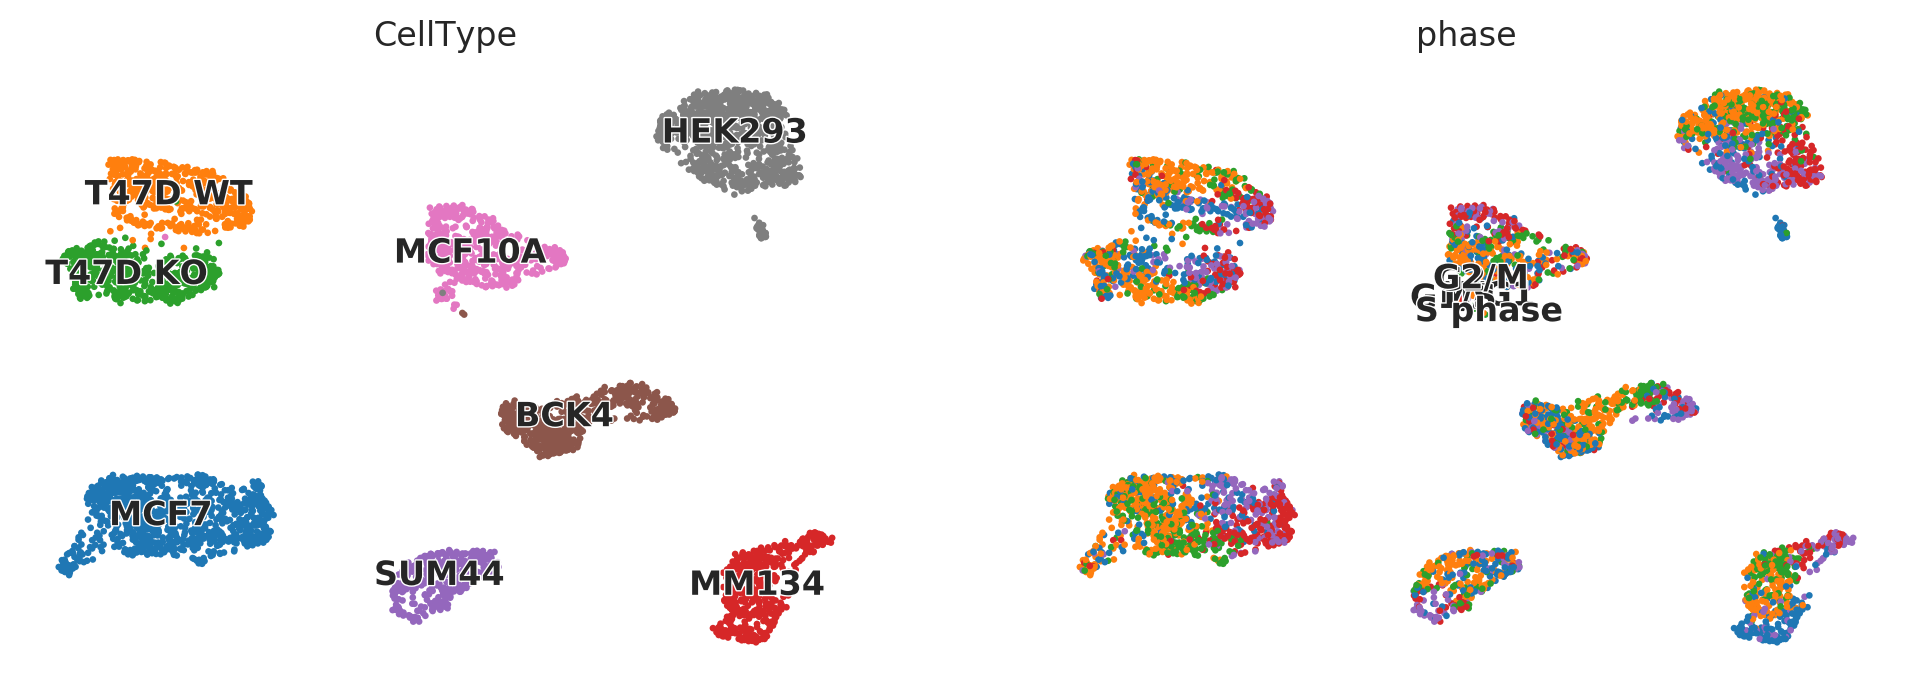

AnnData object with n_obs × n_vars = 4614 × 3000 
    obs: 'Clusters', '_X', '_Y', 'doublet_bln', 'doublet_score', 'percent_mito', 'n_counts', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'louvain', 'CellType', 'phase'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'phase_colors', 'CellType_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [16]:
scv.pl.scatter(AL1, color=['CellType','phase'])
AL1 

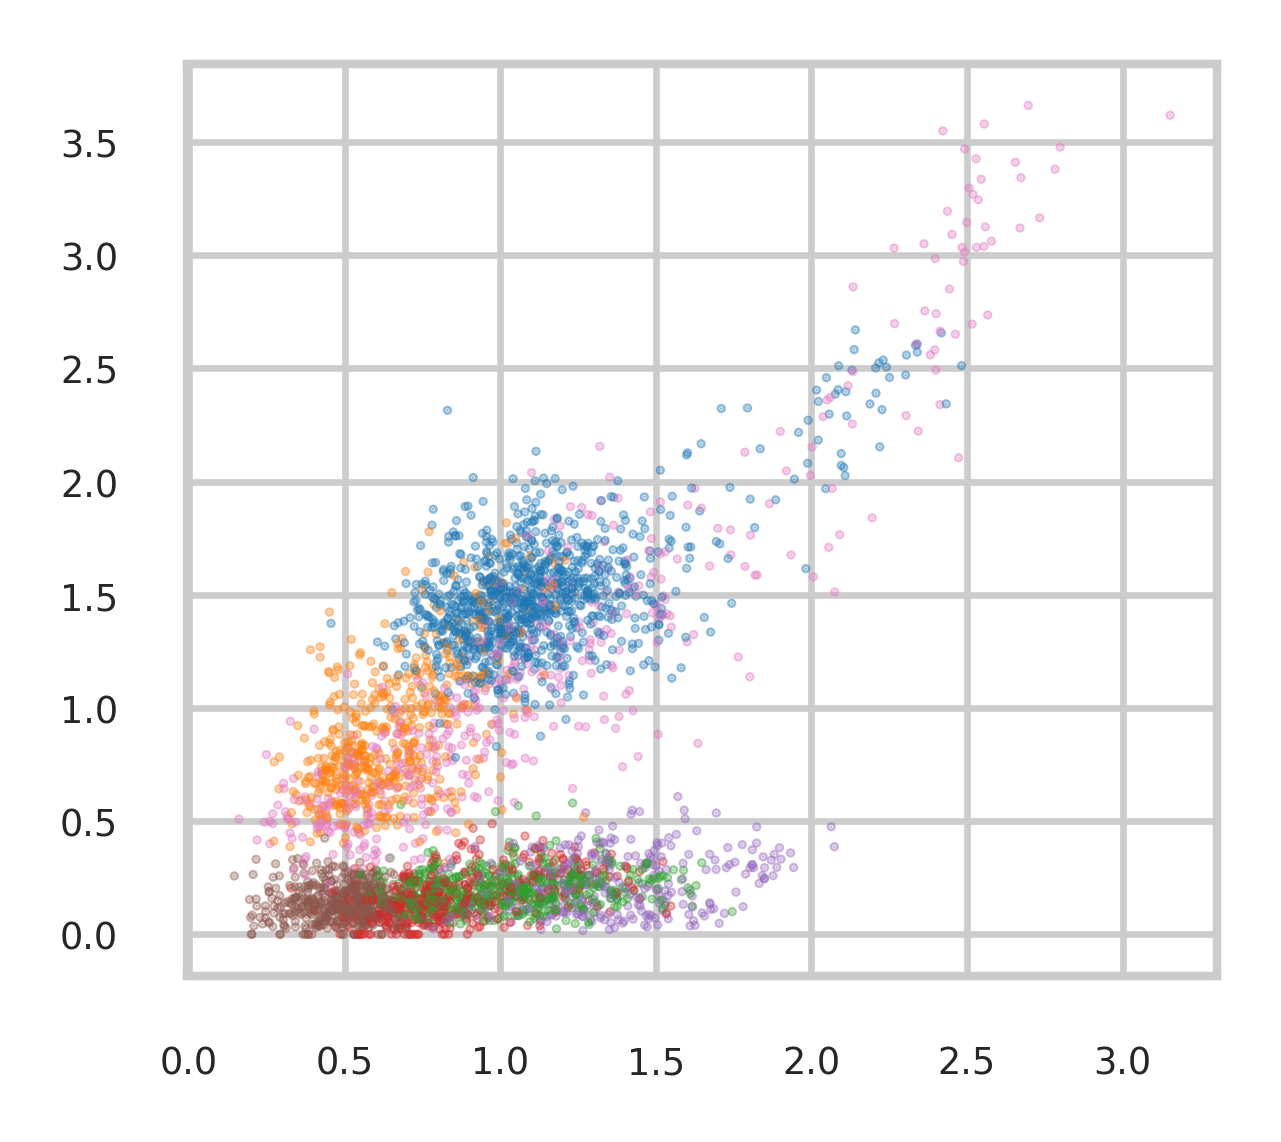

In [33]:
AL1_sel = AL1[AL1.obs['CellType']!='HEK293']
CellTypes = ['MCF7','T47D WT','T47D KO',  'MM134','SUM44','BCK4',  'MCF10A'] # without HEK293

scv.settings.set_figure_params('scvelo')
X = AL1_sel[:,'CDH1'].layers['Mu'].toarray().flatten()
Y = AL1_sel[:,'CDH1'].layers['Ms'].toarray().flatten()
C = AL1_sel[:,'CDH1'].obs['CellType'].values
colors = AL1_sel.uns['CellType_colors'][[np.where(np.array(CellTypes) == x)[0][0] for x in C]]

mpl.rc('figure', dpi=300, figsize=(4,8))
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=.5, color_codes=True)

figure = plt.figure(figsize=(2.2,2))
plt.scatter(X, Y, c=colors, s=.1, alpha=.5)
plt.savefig('../Figure/Fig4/DE_Splicing.png', dpi=300, bbox_inches='tight')

# Refined KO/WT high GO programs

In [73]:
from calcGSVA import * 

## Calc GSVA

In [38]:
!mkdir ../data/gProfiler

In [43]:
wkdir = '/bgfs/alee/chelsea/projects/10X/CellLine'
keyword = 'T47D_WThi'
gmt_path = '{}/data/GSVA/{}.gmt'.format(wkdir, keyword)

fname = '../data/gProfiler/GOBPCC_Intsect_WThi.csv'
sel_dict = {}

df = pd.read_csv(fname, index_col=0, header=None)
for term in df.index:
    genes = df.loc[term,:].values[0].split(',')
    sel_dict[term.replace(' ','_').replace('-','_').replace(',','_')] = genes
write_gmt(sel_dict, gmt_path)    

finished writing 17 gene sets to /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/T47D_WThi.gmt


In [42]:
df.index 

Index(['term_name', 'extracellular exosome', 'extracellular region',
       'extracellular space', 'vesicle', 'extracellular region part',
       'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay',
       'developmental process', 'cytosolic ribosome',
       'positive regulation of biological process', 'adherens junction',
       'cell junction', 'ribosome', 'positive regulation of cellular process',
       'cytosolic part', 'focal adhesion',
       'intracellular non-membrane-bounded organelle'],
      dtype='object', name=0)

In [44]:
g = read_gmt('../data/GSVA/T47D_WThi.gmt')
g.keys()

dict_keys(['term_name', 'extracellular_exosome', 'extracellular_region', 'extracellular_space', 'vesicle', 'extracellular_region_part', 'nuclear_transcribed_mrna_catabolic_process__nonsense_mediated_decay', 'developmental_process', 'cytosolic_ribosome', 'positive_regulation_of_biological_process', 'adherens_junction', 'cell_junction', 'ribosome', 'positive_regulation_of_cellular_process', 'cytosolic_part', 'focal_adhesion', 'intracellular_non_membrane_bounded_organelle'])

In [4]:
wkdir = '/bgfs/alee/chelsea/projects/10X/CellLine'
keyword = 'T47D_KOhi'
gmt_path = '{}/data/GSVA/{}.gmt'.format(wkdir, keyword)

fname = '../data/gProfiler/GOBPCC_Intesect_KOhi.csv'
sel_dict = {}

df = pd.read_csv(fname, index_col=0, header=None)
for term in df.index:
    genes = df.loc[term,:].values[0].split(',')
    sel_dict[term.replace(' ','_')] = genes
write_gmt(sel_dict, gmt_path)    

finished writing 14 gene sets to /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/T47D_KOhi.gmt


In [8]:
wkdir = '/bgfs/alee/chelsea/projects/10X/CellLine'
sample = 'tcga'
keywords = ['T47D_WThi','T47D_KOhi']

for method in ['gsva', 'ssgsea']:
    for kw in keywords:

        gmt_path = '{}/data/GSVA/{}.gmt'.format(wkdir, kw)
        expr_path = '{}/data/TCGA15/tcga.logNormCts.csv'.format(wkdir) # gene x cell
        gsvaPrefix = '{}/data/GSVA/{}_{}'.format(wkdir,sample, kw)

        cmd = 'srun -t1:00:00 --cpus-per-task 12 /ihome/crc/install/gcc-8.2.0/r/3.6.0/bin/Rscript %s/codes/GSVA.R %s %s %s %s &\n'%(wkdir, expr_path, gmt_path, gsvaPrefix, method)
        print(cmd)

srun -t1:00:00 --cpus-per-task 12 /ihome/crc/install/gcc-8.2.0/r/3.6.0/bin/Rscript /bgfs/alee/chelsea/projects/10X/CellLine/codes/GSVA.R /bgfs/alee/chelsea/projects/10X/CellLine/data/TCGA15/tcga.logNormCts.csv /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/T47D_WThi.gmt /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/tcga_T47D_WThi gsva &

srun -t1:00:00 --cpus-per-task 12 /ihome/crc/install/gcc-8.2.0/r/3.6.0/bin/Rscript /bgfs/alee/chelsea/projects/10X/CellLine/codes/GSVA.R /bgfs/alee/chelsea/projects/10X/CellLine/data/TCGA15/tcga.logNormCts.csv /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/T47D_KOhi.gmt /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/tcga_T47D_KOhi gsva &

srun -t1:00:00 --cpus-per-task 12 /ihome/crc/install/gcc-8.2.0/r/3.6.0/bin/Rscript /bgfs/alee/chelsea/projects/10X/CellLine/codes/GSVA.R /bgfs/alee/chelsea/projects/10X/CellLine/data/TCGA15/tcga.logNormCts.csv /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/T47D_WThi.gmt /bgfs/alee/chelsea/projects

In [45]:
!ls ../data/GSVA/tcga*T47D*

../data/GSVA/tcga_T47D_KOhi.gsva.csv	../data/GSVA/tcga_T47D_WThi.gsva.csv
../data/GSVA/tcga_T47D_KOhi.ssgsea.csv	../data/GSVA/tcga_T47D_WThi.ssgsea.csv


## plot
Using original GO terms are not successful:
GSVA: systematically ILCs are lower
ssGSEA: systematically ILCs are higher

use selected go terms: works a lot more consistent

In [3]:
fpath = '/bgfs/alee/chelsea/projects/PublicData/adata/tcga15.h5ad'
tcga = anndata.read_h5ad(fpath)

In [4]:
tcga.obs.groupby(['ONCOTREE_CODE','PAM50']).size().unstack()

PAM50,Basal,Her2,LumA,LumB,Normal
ONCOTREE_CODE,,,,,
BRCA,24.0,7.0,52.0,26.0,4.0
IDC,107.0,51.0,200.0,122.0,9.0
ILC,1.0,2.0,106.0,6.0,12.0
MDLC,4.0,5.0,57.0,22.0,NaN


In [27]:
mpl.rc('figure', dpi=300, figsize=(4,8))
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=.5, color_codes=True)

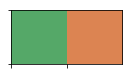

In [19]:
clist = sns.color_palette(palette='deep', desat=1)
sns.palplot([clist[2],clist[1]])  # green: KO/ILC; orange: WT/IDC

### KO hi

In [66]:
sample = 'tcga'
keyword = 'T47D_KOhi'

gsva = pd.read_csv('../data/GSVA/{}_{}.gsva.csv'.format(sample, keyword), index_col=0).T # obs x var
gsva.index = (x.replace('.','-') for x in gsva.index) 

from scipy.stats import * 

df_p = tcga.obs 
df_p = df_p.join(gsva)

glist = gsva.columns
ks_res = np.empty((len(glist), 3))
df_p_sel = df_p[df_p['PAM50'].isin(['LumA'])]

for n, g in enumerate(glist):
    x1 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='ILC'].values
    x2 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='IDC'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 

    stat, p = ks_2samp(x1, x2)
    sg_stat = stat if np.mean(x1) > np.mean(x2) else (-1)*stat # ILC minus IDC
    ks_res[n,:] = [stat, sg_stat, p]
    
ks_df = pd.DataFrame(ks_res, columns=['ks','sg_ks','p'], index=glist).sort_values(by='sg_ks', ascending=False)

from statsmodels.stats.multitest import multipletests
ks_df['FDR'] = multipletests(ks_df['p'])[1] 

ks_df[ks_df['FDR']<0.05] 

,ks,sg_ks,p,FDR
response_to_oxygen_levels,0.214151,0.214151,0.002824,0.036098
response_to_hypoxia,0.214151,0.214151,0.002824,0.036098


In [67]:
Sigks_df = ks_df.index[ks_df['FDR']<0.05]
print('%d terms tested for enrichement in LumA ILC & IDC, \n%d terms with FDR<0.05'%(ks_df.shape[0], Sigks_df.shape[0]))


13 terms tested for enrichement in LumA ILC & IDC, 
2 terms with FDR<0.05


In [68]:
mpl.style.use('NaturePub')
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=.7, color_codes=True)

response_to_oxygen_levels ;p: 0.001; 106 ILC: 0.09 200 IDC: -0.00
response_to_hypoxia ;p: 0.001; 106 ILC: 0.09 200 IDC: -0.00


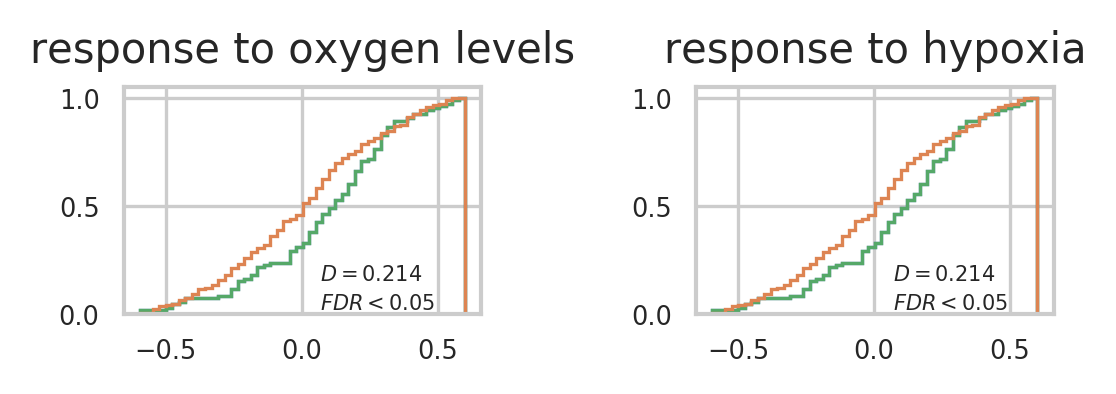

In [69]:
from scipy.stats import mannwhitneyu
glist = ks_df.index[ks_df['FDR']<0.05]
n_bins = 50

nplots = len(glist)
ncols = 2
nrows = 1

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*2, nrows*1), dpi=300)
plt.subplots_adjust(wspace=0.6, hspace=0.8) # 
axes_list = axes.flatten()

df_p_sel = df_p[df_p['PAM50'].isin(['LumA'])] # LumA only

k = -1 
for g in glist:
    if g in df_p_sel.columns:
        
        x1 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='ILC'].values
        x2 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='IDC'].values
        x1 = x1[abs(x1) < 1e308] 
        x2 = x2[abs(x2) < 1e308] 
        _, p = mannwhitneyu(x1, x2)


        print(g, ';p: %.3f;'%p,'%d ILC: %.2f'%(len(x1), np.mean(x1)), '%d IDC: %.2f'%(len(x2), np.mean(x2)))
        k += 1
        ax = axes_list[k]
        n, bins, patches = ax.hist(x1, n_bins, density=True, histtype='step', cumulative=True)
        ax.hist(x1, bins=bins, histtype='step', cumulative=True, density=True, label='ILC', color=clist[2])
        ax.hist(x2, bins=bins, histtype='step', cumulative=True, density=True, label='IDC', color=clist[1])

        ax.set_title(g.replace('_',' '), fontsize=10)
        
        ks, fdr = ks_df.loc[g, ['sg_ks','FDR']].values
        if fdr < 0.05:
            ax.text(0.55, 0.02, '${FDR}<0.05$', fontsize=5, transform = ax.transAxes) 
            ax.text(0.55, 0.15, '${D}=$%.3f'%ks, fontsize=5, transform = ax.transAxes) # IDC high is positive


plt.savefig('../Figure/Fig4/tcga_RefinedGO_KOhi.png', dpi=300, bbox_inches='tight')

### WT hi

In [31]:
!ls ../data/GSVA/*tcga*gsva*

../data/GSVA/tcga_ApopSig.gsva.csv
../data/GSVA/tcga_CellCycle.gsva.csv
../data/GSVA/tcga_EpiDiff1.gsva.csv
../data/GSVA/tcga_EpiDiff2.gsva.csv
../data/GSVA/tcga_h.all.v6.2.symbols.gsva.csv
../data/GSVA/tcga_hypoxia.gsva.csv
../data/GSVA/tcga_PaRfDown.gsva.csv
../data/GSVA/tcga_PaRfUp.gsva.csv
../data/GSVA/tcga_PaSwneDown.gsva.csv
../data/GSVA/tcga_PaSwneUp.gsva.csv
../data/GSVA/tcga_pEMT1.gsva.csv
../data/GSVA/tcga_stress.gsva.csv
../data/GSVA/tcga_T47D_KOhi.gsva.csv
../data/GSVA/tcga_T47D_WThi.gsva.csv


In [46]:
sample = 'tcga'
keyword = 'T47D_WThi'

gsva = pd.read_csv('../data/GSVA/{}_{}.gsva.csv'.format(sample, keyword), index_col=0).T # obs x var
gsva.index = (x.replace('.','-') for x in gsva.index) 

from scipy.stats import * 

df_p = tcga.obs 
df_p = df_p.join(gsva)

glist = gsva.columns
ks_res = np.empty((len(glist), 3))
df_p_sel = df_p[df_p['PAM50'].isin(['LumA'])]

for n, g in enumerate(glist):
    x1 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='ILC'].values
    x2 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='IDC'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 

    stat, p = ks_2samp(x1, x2)
    sg_stat = stat if np.mean(x1) > np.mean(x2) else (-1)*stat # ILC minus IDC
    ks_res[n,:] = [stat, sg_stat, p]
    
ks_df = pd.DataFrame(ks_res, columns=['ks','sg_ks','p'], index=glist).sort_values(by='sg_ks', ascending=False)

from statsmodels.stats.multitest import multipletests
ks_df['FDR'] = multipletests(ks_df['p'])[1] 

ks_df[ks_df['FDR']<0.05] 

,ks,sg_ks,p,FDR
intracellular_non_membrane_bounded_organelle,0.208113,-0.208113,0.004061,0.028080
positive_regulation_of_biological_process,0.242264,-0.242264,0.000451,0.003599
cell_junction,0.253302,-0.253302,0.000206,0.001856
vesicle,0.261132,-0.261132,0.000116,0.001157
extracellular_region,0.264811,-0.264811,0.000089,0.000975
positive_regulation_of_cellular_process,0.266604,-0.266604,0.000077,0.000921
extracellular_space,0.273774,-0.273774,0.000044,0.000574
extracellular_exosome,0.281887,-0.281887,0.000023,0.000326
extracellular_region_part,0.283774,-0.283774,0.000020,0.000298
developmental_process,0.306038,-0.306038,0.000003,0.000048


In [47]:
Sigks_df = ks_df.index[ks_df['FDR']<0.05]
print('%d terms tested for enrichement in LumA ILC & IDC, \n%d terms with FDR<0.05'%(ks_df.shape[0], Sigks_df.shape[0]))


16 terms tested for enrichement in LumA ILC & IDC, 
10 terms with FDR<0.05


In [48]:
mpl.style.use('NaturePub')
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=.7, color_codes=True)

intracellular_non_membrane_bounded_organelle ;p: 0.005; 106 ILC: -0.15 200 IDC: -0.07
positive_regulation_of_biological_process ;p: 0.000; 106 ILC: -0.11 200 IDC: -0.01
cell_junction ;p: 0.000; 106 ILC: -0.10 200 IDC: 0.03
vesicle ;p: 0.000; 106 ILC: -0.15 200 IDC: -0.01
extracellular_region ;p: 0.000; 106 ILC: -0.14 200 IDC: -0.00
positive_regulation_of_cellular_process ;p: 0.000; 106 ILC: -0.13 200 IDC: -0.02
extracellular_space ;p: 0.000; 106 ILC: -0.15 200 IDC: -0.01
extracellular_exosome ;p: 0.000; 106 ILC: -0.18 200 IDC: -0.02
extracellular_region_part ;p: 0.000; 106 ILC: -0.15 200 IDC: -0.01
developmental_process ;p: 0.000; 106 ILC: -0.10 200 IDC: 0.03


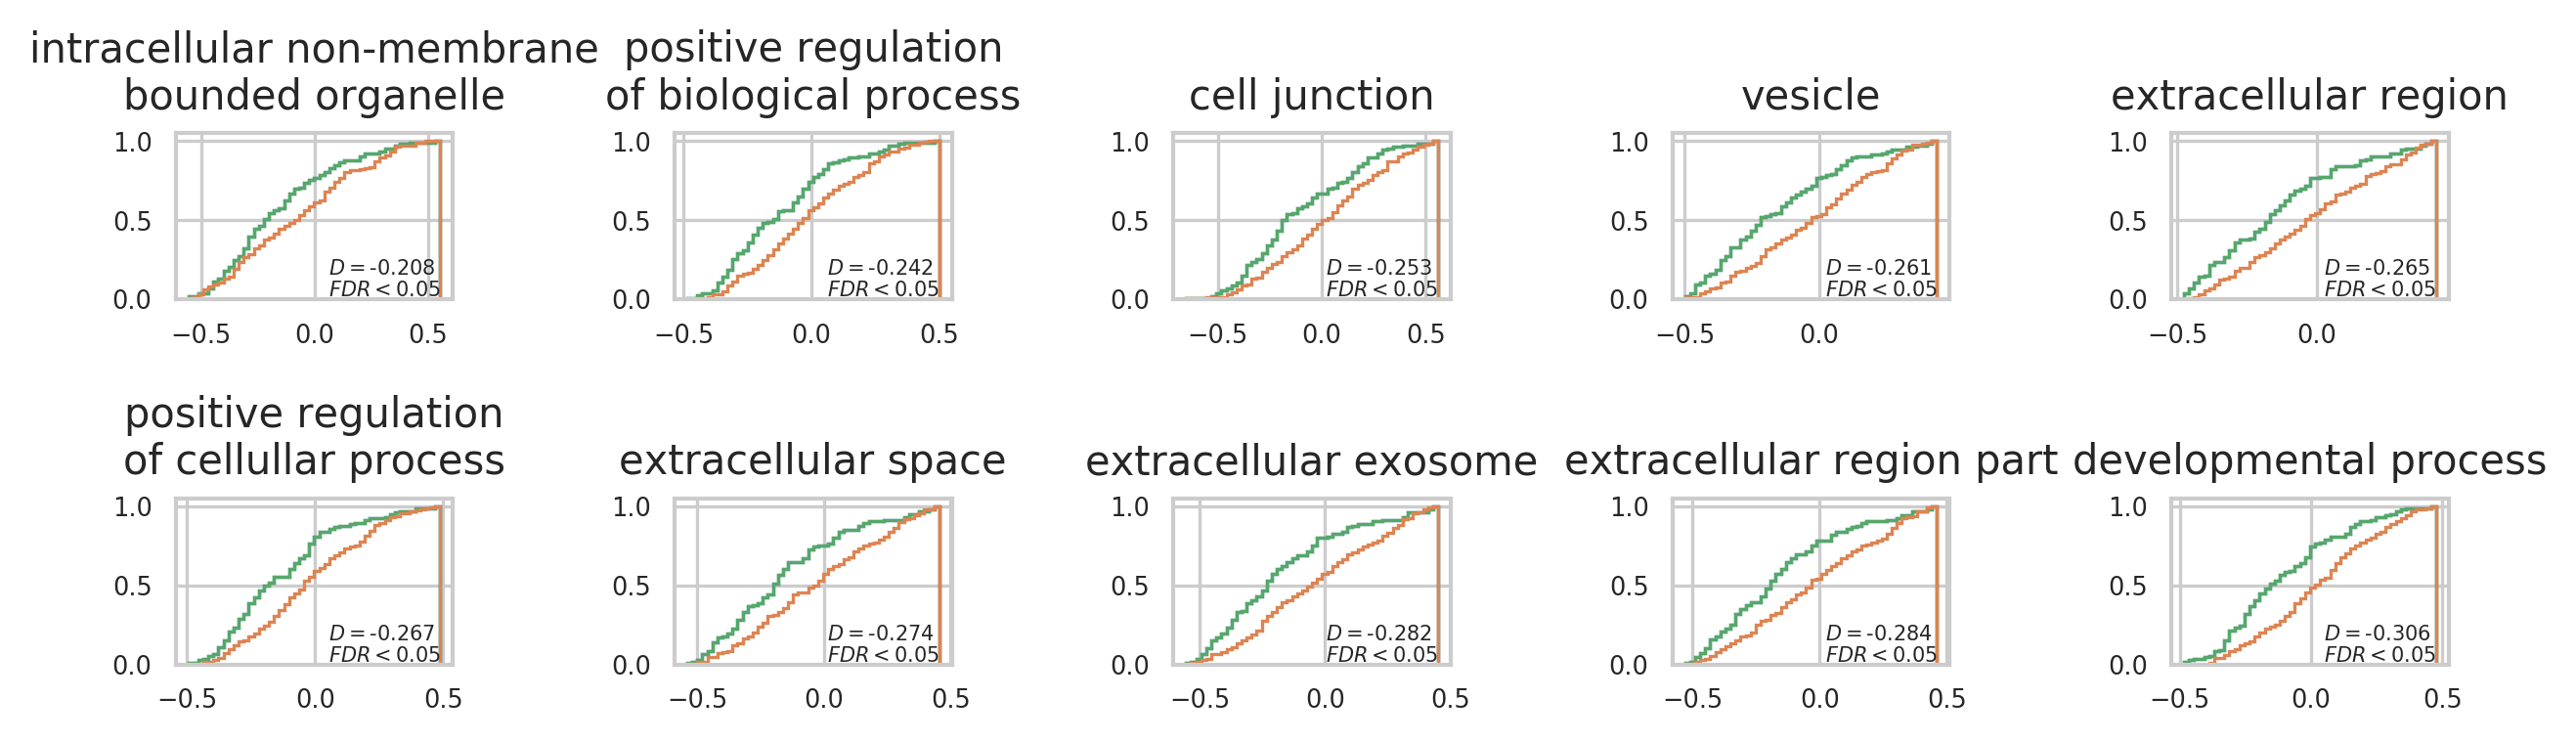

In [65]:
from scipy.stats import mannwhitneyu
glist = ks_df.index[ks_df['FDR']<0.05]
n_bins = 50

nplots = len(glist)
ncols = 5 
nrows = ceil(nplots/ncols)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*2, nrows*1.2), dpi=300)
plt.subplots_adjust(wspace=.8, hspace=1.2) # 
axes_list = axes.flatten()

df_p_sel = df_p[df_p['PAM50'].isin(['LumA'])] # LumA only

k = -1 
for g in ks_df[ks_df['FDR']<0.05].index:
        
    x1 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='ILC'].values
    x2 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='IDC'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 
    _, p = mannwhitneyu(x1, x2)


    print(g, ';p: %.3f;'%p,'%d ILC: %.2f'%(len(x1), np.mean(x1)), '%d IDC: %.2f'%(len(x2), np.mean(x2)))
    k += 1
    ax = axes_list[k]
    n, bins, patches = ax.hist(x1, n_bins, density=True, histtype='step', cumulative=True)
    ax.hist(x1, bins=bins, histtype='step', cumulative=True, density=True, label='ILC', color=clist[2])
    ax.hist(x2, bins=bins, histtype='step', cumulative=True, density=True, label='IDC', color=clist[1])

    title = g.replace('_',' ')
    if title.startswith('intracellular'):
        title = 'intracellular non-membrane\nbounded organelle'
    elif title == 'positive regulation of biological process':
        title = 'positive regulation\nof biological process'
    elif title == 'positive regulation of cellular process':
        title = 'positive regulation\nof cellullar process'
    ax.set_title(title, fontsize=10)
    

    ks, fdr = ks_df.loc[g, ['sg_ks','FDR']].values
    if fdr < 0.05:
        ax.text(0.55, 0.02, '${FDR}<0.05$', fontsize=5, transform = ax.transAxes) 
        ax.text(0.55, 0.15, '${D}=$%.3f'%ks, fontsize=5, transform = ax.transAxes) # IDC high is positive


plt.savefig('../Figure/Fig4/tcga_RefinedGO_WThi.png', dpi=300, bbox_inches='tight')

### Deduced target genes from candidate regulons

In [ ]:
sample = 'tcga'
keyword = 'Regulon'

gsva = pd.read_csv('../data/GSVA2/{}_{}.gsva.csv'.format(sample, keyword), index_col=0).T # obs x var
gsva.index = (x.replace('.','-') for x in gsva.index) 

from scipy.stats import * 

df_p = tcga.obs 
df_p = df_p.join(gsva)

glist = gsva.columns
ks_res = np.empty((len(glist), 3))
df_p_sel = df_p[df_p['PAM50'].isin(['LumA'])]

for n, g in enumerate(glist):
    x1 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='ILC'].values
    x2 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='IDC'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 

    
    stat, p = ks_2samp(x1, x2)
    sg_stat = stat if np.mean(x1) > np.mean(x2) else (-1)*stat # ILC minus IDC
    ks_res[n,:] = [stat, sg_stat, p]
    
ks_df = pd.DataFrame(ks_res, columns=['ks','sg_ks','p'], index=glist).sort_values(by='sg_ks', ascending=False)

from statsmodels.stats.multitest import multipletests
ks_df['FDR'] = multipletests(ks_df['p'])[1] 

ks_df[ks_df['FDR']<0.05] 


IRF1 ;p: 0.000; 106 ILC: 0.16 200 IDC: 0.04
PITX1 ;p: 0.003; 106 ILC: -0.16 200 IDC: -0.09
JUND ;p: 0.001; 106 ILC: -0.07 200 IDC: -0.02
FOS ;p: 0.000; 106 ILC: -0.09 200 IDC: -0.02
E2F6 ;p: 0.000; 106 ILC: -0.21 200 IDC: -0.11
CTCF ;p: 0.000; 106 ILC: -0.19 200 IDC: -0.09
EGR1 ;p: 0.000; 106 ILC: -0.10 200 IDC: -0.01


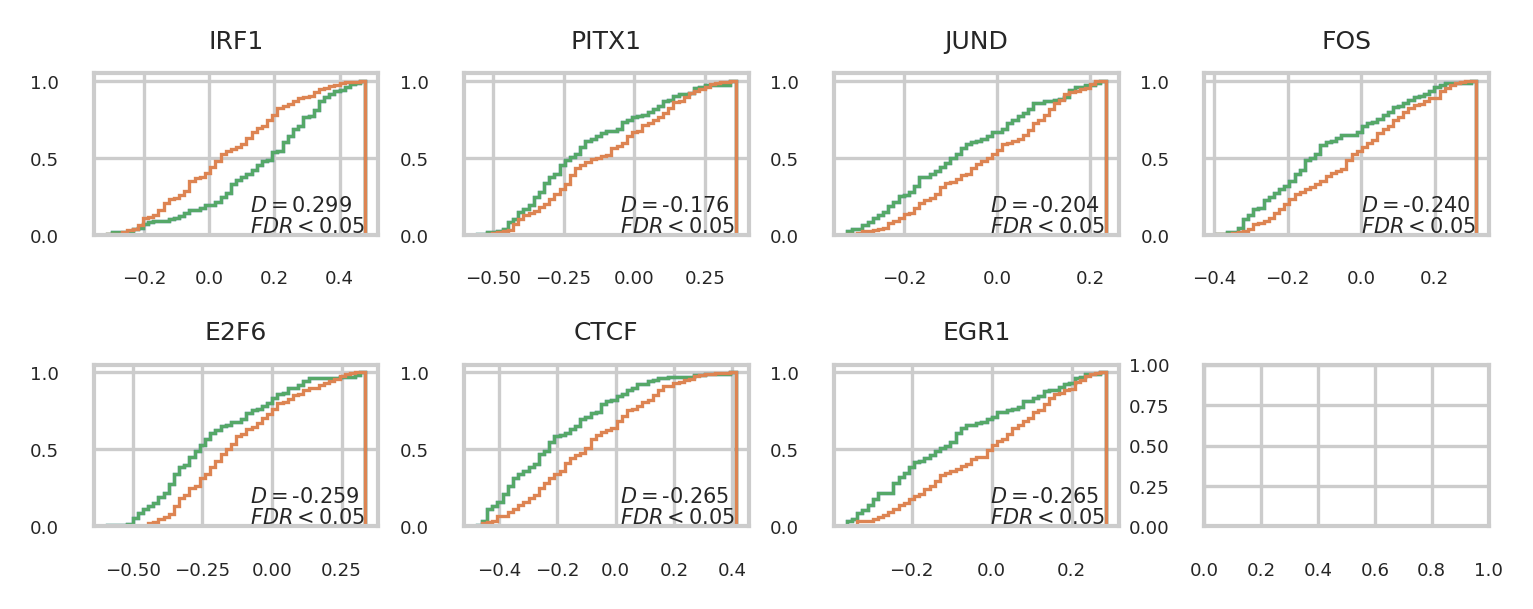

In [9]:
from scipy.stats import mannwhitneyu
glist = ks_df.index[ks_df['FDR']<0.05]
n_bins = 50

nplots = len(glist)
ncols = 4
nrows = ceil(nplots/ncols)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*1.5, nrows*1), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=0.8) # 
axes_list = axes.flatten()

df_p_sel = df_p[df_p['PAM50'].isin(['LumA'])]

k = -1 
for g in glist:
    if g in df_p_sel.columns:
        x1 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='ILC'].values
        x2 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='IDC'].values
        x1 = x1[abs(x1) < 1e308] 
        x2 = x2[abs(x2) < 1e308] 
        _, p = mannwhitneyu(x1, x2)


        k += 1 
        print(g, ';p: %.3f;'%p,'%d ILC: %.2f'%(len(x1), np.mean(x1)), '%d IDC: %.2f'%(len(x2), np.mean(x2)))

        ax = axes_list[k]
    #     sns.boxplot(data=df_p_sel, x='PAM50',y=g, hue='ONCOTREE_CODE', ax=ax)
        n, bins, patches = ax.hist(x1, n_bins, density=True, histtype='step', cumulative=True)
        ax.hist(x1, bins=bins, histtype='step', cumulative=True, density=True, label='ILC', color=clist[2])
        ax.hist(x2, bins=bins, histtype='step', cumulative=True, density=True, label='IDC', color=clist[1])

#         sns.distplot(x2, label='IDC',ax=ax)

        ax.set_title(g, fontsize=6)
        ks, fdr = ks_df.loc[g, ['sg_ks','FDR']].values
        ax.text(0.55, 0.15, '${D}=$%.3f'%ks, fontsize=5, transform = ax.transAxes) # IDC high is positive
        if fdr < 0.05:
            ax.text(0.55, 0.02, '${FDR}<0.05$', fontsize=5, transform = ax.transAxes) 


## LitRef 
### IRF1

- [The Role of Interferon Regulatory Factor-1 (IRF1) in Overcoming Antiestrogen Resistance in the Treatment of Breast Cancer.](https://www.ncbi.nlm.nih.gov/pubmed/22295238)
- [Interferon regulatory factor 1 (IRF-1) and IRF-2 expression in breast cancer tissue microarrays](https://www.ncbi.nlm.nih.gov/pubmed/16241857)
- [Interferon regulatory factor 1 inactivation in human cancer](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5938431/)
- [Interferon regulatory factor-1 (IRF-1) exhibits tumor suppressor activities in breast cancer associated with caspase activation and induction of apoptosis](https://academic.oup.com/carcin/article/26/9/1527/2390934)

### CDH1
- [Tumor suppressor gene E-cadherin and its role in normal and malignant cells](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC270068/) [doi:10.1186/1475-2867-3-17]